In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse, r2_score

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ceciliakemiac/DataScienceMaybeFiles/master/data/cartola_20142.csv')
df.shape

(29184, 34)

In [0]:
df.head()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,nota,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,37958,1,262.0,1,1.0,1,8.0,8.0,19.69,1.69,179872.0,1,1.0,0,1.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,68873,1,262.0,0,1.0,0,0.0,0.0,4.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37701,1,262.0,1,2.0,1,0.4,0.4,16.97,-5.03,179872.0,1,1.0,0,1.0,6.0,0,7,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
3,71602,1,262.0,0,2.0,0,0.0,0.0,3.00,0.00,179872.0,1,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37684,1,262.0,1,3.0,1,9.1,9.1,10.68,5.68,179872.0,1,1.0,0,1.0,6.0,2,1,0,0,1,0,0,1,0,2,1,0,0,0,1,0,0,0


# Parte 1

## Análise Exploratória e Pre-processamento dos dados

Vamos ver a correlação entre as variáveis

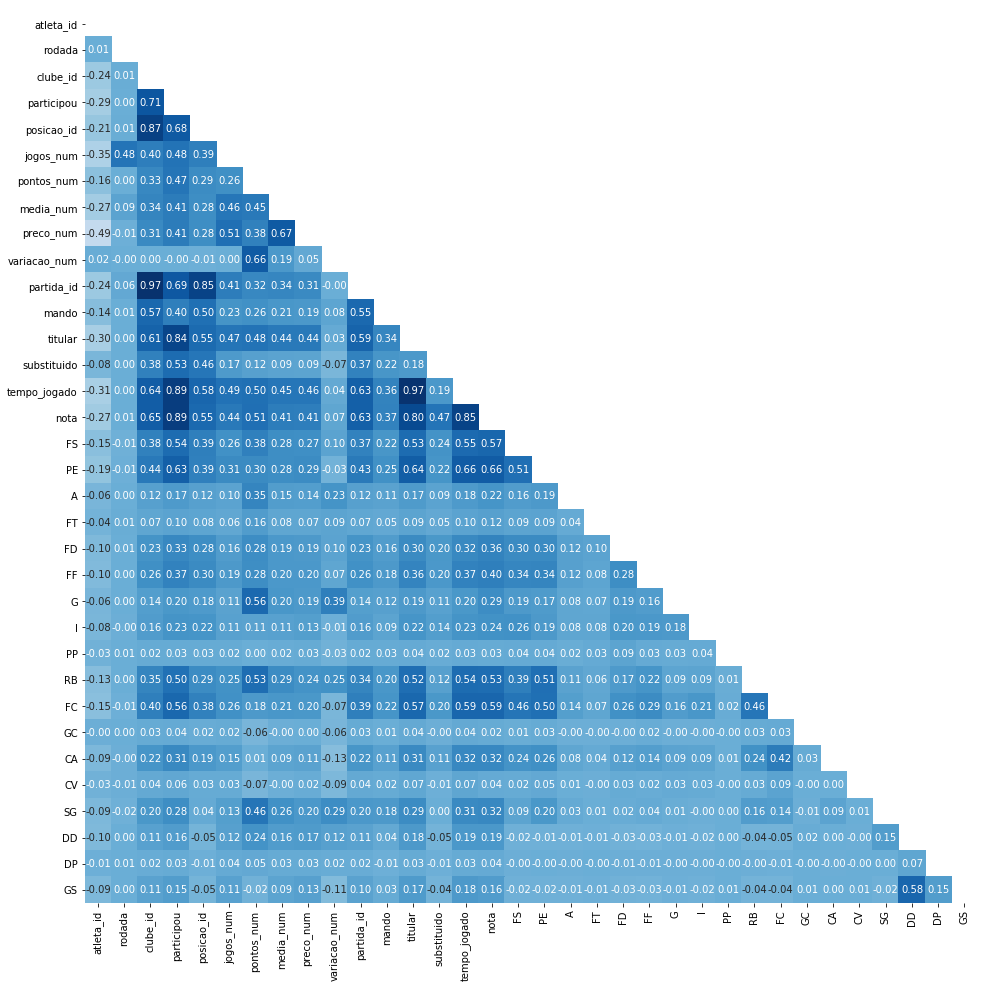

In [0]:
correlation = df.corr(method='pearson')
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 18)
sns.heatmap(correlation, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Blues, center=0)

Vemos que as variáveis com maior correlação entre si são partida_id e clube_id, posicao_id e clube_id, tempo_jogado e participou, tempo_jogado e titular. As que possuem maior correlação em relação a nota são nota e participou, nota e titular e nota e tempo_jogado.

Agora, para todos os atletas que não participaram na rodada, iremos colocar a sua nota como 0, pois não faz sentido ele receber uma nota se não tiver jogado.

In [0]:
for index, row in df.iterrows():
  if row['participou'] == 0:
    df.loc[index, 'nota'] = 0.0

Como a variável dependente é nota, vamos separá-la das outras para podermos prevê-la melhor

In [0]:
notas = df.nota
notas.shape

(29184,)

In [0]:
df.drop('nota', axis = 1, inplace = True)

In [0]:
df.shape

(29184, 33)

Normalização dos atributos

In [0]:
standardscaler = StandardScaler()
standardscaler = standardscaler.fit(df)
df_norm = standardscaler.transform(df)

df_norm = pd.DataFrame(df_norm)
df_norm.columns = df.columns
df_norm.index = df.index

# df_clean = df_s
df_norm.head()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,-1.847292,-1.685014,0.790063,1.326445,-0.436628,-0.716585,2.536688,3.118339,2.995064,2.294245,0.914376,1.651569,1.542385,-0.407897,1.637237,-0.406746,-0.472801,-0.131362,-0.07427,-0.246694,-0.280662,-0.150205,-0.175954,-0.024843,-0.373349,-0.425185,-0.028084,-0.236269,-0.046881,4.686305,3.313047,-0.020282,-0.113455
1,0.008833,-1.685014,0.790063,-0.753895,-0.436628,-0.850190,-0.352931,-0.772583,-0.340084,0.000066,0.914376,1.651569,-0.648347,-0.407897,-0.688091,-0.406746,-0.472801,-0.131362,-0.07427,-0.246694,-0.280662,-0.150205,-0.175954,-0.024843,-0.373349,-0.425185,-0.028084,-0.236269,-0.046881,-0.213037,-0.117551,-0.020282,-0.113455
2,-1.862722,-1.685014,0.790063,1.326445,0.056162,-0.716585,-0.208450,-0.578037,2.416886,-6.828172,0.914376,1.651569,1.542385,-0.407897,1.637237,-0.406746,3.873880,-0.131362,-0.07427,-0.246694,-0.280662,-0.150205,-0.175954,-0.024843,-0.373349,0.645076,-0.028084,4.220931,-0.046881,4.686305,-0.117551,-0.020282,-0.113455
3,0.172681,-1.685014,0.790063,-0.753895,0.056162,-0.850190,-0.352931,-0.772583,-0.552649,0.000066,0.914376,1.651569,-0.648347,-0.407897,-0.688091,-0.406746,-0.472801,-0.131362,-0.07427,-0.246694,-0.280662,-0.150205,-0.175954,-0.024843,-0.373349,-0.425185,-0.028084,-0.236269,-0.046881,-0.213037,-0.117551,-0.020282,-0.113455
4,-1.863743,-1.685014,0.790063,1.326445,0.548952,-0.716585,2.934010,3.653341,1.079851,7.710679,0.914376,1.651569,1.542385,-0.407897,1.637237,1.742339,0.148153,-0.131362,-0.07427,2.884888,-0.280662,-0.150205,3.427593,-0.024843,2.027932,0.645076,-0.028084,-0.236269,-0.046881,4.686305,-0.117551,-0.020282,-0.113455


# Parte 2

Abaixo, função que retorna o rmse calculado para determinado modelo, utilizando cross validation, que utilizaremos para encontrar o melhor valor de parâmetro que precisaremos utilizar para os modelos.

In [0]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, df_norm, notas, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

## Regressão Ridge com validação cruzada

Text(0, 0.5, 'rmse')

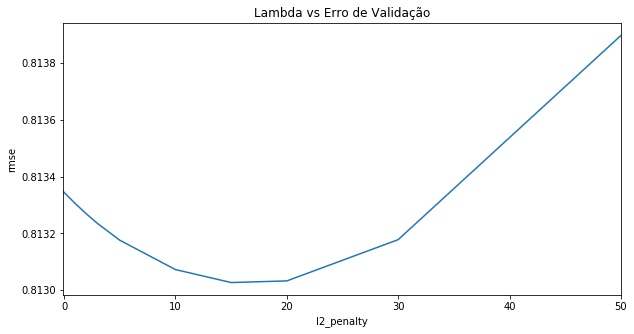

In [0]:
alphas = [0,1e-03,1e-02,1e-01,1,2,3,5,10,15,20,30,50]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)

plt.figure(figsize=(10, 5))
cv_ridge.plot(title="Lambda vs Erro de Validação")
plt.xlabel("l2_penalty")
plt.ylabel("rmse")


In [0]:
best_l2_penalty=cv_ridge.argmin()
best_rmse = cv_ridge.min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [0]:
print (best_l2_penalty, best_rmse)

15.0 0.8130271106918375


Para o modelo Ridge, vemos que o melhor valor do rmse foi 0.81302, aproximadamente, para lambda igual a 15.

## Regressão Lasso com validação cruzada

Text(0, 0.5, 'rmse')

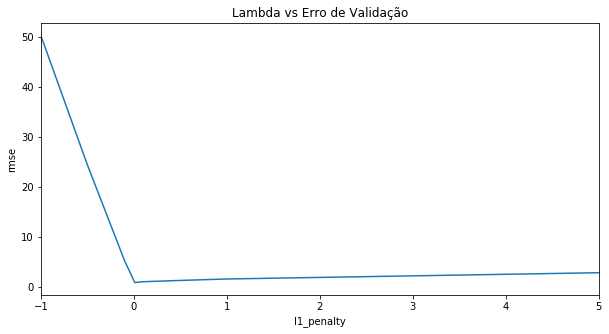

In [0]:
alphas = [-1,-0.5,-0.1,0.01,0.1,0.5,1,5]
cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index=alphas)

plt.figure(figsize=(10, 5))
cv_lasso.plot(title="Lambda vs Erro de Validação")
plt.xlabel("l1_penalty")
plt.ylabel("rmse")


In [0]:
best_l1_penalty=cv_lasso.argmin()
best_rmse = cv_lasso.min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [0]:
print (best_l1_penalty, best_rmse)

0.01 0.852859235168078


Para o modelo Lasso, o melhor valor do rmse foi 0.8528, para o lambda igual a 0.01. 

## Regressão KNN com validação cruzada

Text(0, 0.5, 'rmse')

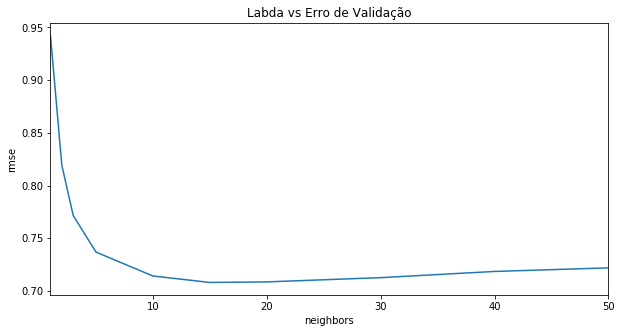

In [0]:
alphas = [1,2,3,5,10,15,20,30,40,50]
cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors=alpha)).mean() for alpha in alphas]
cv_knn = pd.Series(cv_knn, index=alphas)
cv_knn

plt.figure(figsize=(10, 5))
cv_knn.plot(title="Labda vs Erro de Validação")
plt.xlabel("neighbors")
plt.ylabel("rmse")

In [0]:
best_neighbor=cv_knn.argmin()
best_rmse = cv_knn.min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [0]:
print (best_neighbor, best_rmse)

15 0.7081006278772208


Para o modelo KNN, o melhor valor do rmse foi 0.7081, com o número de vizinhos igual a 15.

Com isso, vemos que o melhor modelo foi o KNN, sendo que o Ridge e o Lasso ficaram um pouco próximos.

# Parte 3

## Variáveis mais importantes para o Ridge

In [0]:
model_ridge = Ridge(alpha=best_l2_penalty)
model_ridge.fit(df_norm, notas)

Ridge(alpha=15.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
coef = pd.Series(model_ridge.coef_, index = df_norm.columns)

imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])
coef

atleta_id       0.011011
rodada          0.006816
clube_id        0.211653
participou      1.622205
posicao_id     -0.355958
jogos_num       0.022860
pontos_num     -2.382641
media_num      -0.039585
preco_num       0.036925
variacao_num   -0.030058
partida_id      0.024175
mando           0.042299
titular        -0.426192
substituido     0.216113
tempo_jogado    0.984220
FS              0.509737
PE             -0.319289
A               0.760255
FT              0.271312
FD              0.373782
FF              0.319079
G               1.474938
I              -0.109291
PP             -0.098999
RB              1.354368
FC             -0.305586
GC             -0.183405
CA             -0.386211
CV             -0.277920
SG              0.999997
DD              0.902609
DP              0.147814
GS             -0.415949
dtype: float64

Vemos, com esse resultado, que as variáveis mais importantes para o modelo Ridge são participou, pontos_num, tempo_jogado, A, G, RB, SG e DD.

## Variáveis mais importantes para o Lasso

In [0]:
model_lasso = Lasso(alpha=best_l1_penalty)
model_lasso.fit(df_norm, notas)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
coef = pd.Series(model_lasso.coef_, index = df_norm.columns)

imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])
coef

atleta_id       0.000000
rodada          0.000000
clube_id        0.262229
participou      1.632170
posicao_id     -0.404767
jogos_num       0.016654
pontos_num     -1.181657
media_num      -0.010260
preco_num       0.000000
variacao_num   -0.031744
partida_id      0.022807
mando           0.021911
titular        -0.131565
substituido     0.219302
tempo_jogado    0.448621
FS              0.335196
PE             -0.008784
A               0.441555
FT              0.151712
FD              0.242303
FF              0.211987
G               0.872390
I              -0.022036
PP             -0.051009
RB              0.765574
FC             -0.030892
GC             -0.096447
CA             -0.174437
CV             -0.160711
SG              0.590392
DD              0.527829
DP              0.075544
GS             -0.146754
dtype: float64

Vemos, com esses valores, que as variáveis mais importantes para o modelo Lasso são participou, pontos_num, tempo_jogado, G e RB.

Algumas variáveis foram zeradas, dentre elas temos atleta_id, rodada e preco_num.

# Parte 4

Dados de teste

In [0]:
teste = pd.read_csv('https://raw.githubusercontent.com/ceciliakemiac/DataScienceMaybeFiles/master/data/test.csv')
teste.shape


(1610, 33)

Removendo elementos NaN

In [0]:
imputer = Imputer(strategy='mean')
imputer = imputer.fit(teste)
teste_pre = imputer.transform(teste)

teste_pre = pd.DataFrame(teste_pre)
teste_pre.columns = teste.columns
teste_pre.index = teste.index

teste_pre.head()


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,68873.0,37.0,262.0,1.0,1.0,29.0,10.1,4.81,9.88,0.22,180166.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
1,78086.0,37.0,262.0,0.0,1.0,0.0,0.0,0.00,2.00,0.00,180166.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,89258.0,37.0,262.0,0.0,1.0,0.0,0.0,0.00,1.00,0.00,180166.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,37701.0,37.0,262.0,1.0,2.0,33.0,1.7,2.82,10.09,0.26,180166.0,1.0,1.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,50453.0,37.0,262.0,1.0,2.0,8.0,10.0,7.20,6.15,1.55,180166.0,1.0,0.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Normalizando os dados de teste:

In [0]:
standardscaler = StandardScaler()
standardscaler = standardscaler.fit(teste_pre)
teste_pre = standardscaler.transform(teste_pre)

teste_pre = pd.DataFrame(teste_pre)
teste_pre.columns = teste.columns
teste_pre.index = teste.index

# df_clean = df_s
teste_pre.head()

,atleta_id,rodada,clube_id,participou,posicao_id,jogos_num,pontos_num,media_num,preco_num,variacao_num,partida_id,mando,titular,substituido,tempo_jogado,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
0,-0.032408,-1.002488,-1.933642,1.306094,-2.530859,1.430028,3.274507,1.624701,1.009504,0.390749,-0.022768,1.635787,1.200924,-0.408248,1.333051,-0.425995,1.291595,-0.163663,-0.090223,-0.26667,-0.339196,-0.184393,-0.17547,-0.02493,-0.410238,-0.454135,-0.035267,-0.261485,-0.123014,5.420088,6.188535,-0.02493,-0.131719
1,0.511751,-1.002488,-1.933642,-0.765641,-2.530859,-1.151775,-0.348542,-1.024326,-0.783021,-0.000763,-0.022768,1.635787,-1.597896,-0.408248,-1.773698,-0.425995,-0.521894,-0.163663,-0.090223,-0.26667,-0.339196,-0.184393,-0.17547,-0.02493,-0.410238,-0.454135,-0.035267,-0.261485,-0.123014,-0.184499,-0.133509,-0.02493,-0.131719
2,1.171615,-1.002488,-1.933642,-0.765641,-2.530859,-1.151775,-0.348542,-1.024326,-1.010499,-0.000763,-0.022768,1.635787,-1.597896,-0.408248,-1.773698,-0.425995,-0.521894,-0.163663,-0.090223,-0.26667,-0.339196,-0.184393,-0.17547,-0.02493,-0.410238,-0.454135,-0.035267,-0.261485,-0.123014,-0.184499,-0.133509,-0.02493,-0.131719
3,-1.873556,-1.002488,-1.933642,1.306094,-1.520683,1.786139,0.261278,0.528742,1.057275,0.461932,-0.022768,1.635787,1.200924,2.449490,-0.220324,-0.425995,0.082602,-0.163663,-0.090223,-0.26667,-0.339196,-0.184393,-0.17547,-0.02493,-0.410238,1.705858,-0.035267,3.747946,-0.123014,5.420088,-0.133509,-0.02493,-0.131719
4,-1.120369,-1.002488,-1.933642,1.306094,-1.520683,-0.439554,3.238635,2.940953,0.161012,2.757612,-0.022768,1.635787,-1.597896,2.449490,-0.220324,-0.425995,0.082602,-0.163663,-0.090223,-0.26667,2.014706,-0.184393,-0.17547,-0.02493,3.121761,0.625862,-0.035267,-0.261485,-0.123014,5.420088,-0.133509,-0.02493,-0.131719


## Predição com KNN

In [0]:
model_knn = KNeighborsRegressor(n_neighbors = 15)
model_knn.fit(df_norm, notas)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [0]:
knnPredict = model_knn.predict(teste_pre)


In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/ceciliakemiac/DataScienceMaybeFiles/master/data/sample_submission.csv')
data.nota = knnPredict

data.to_csv('knn_nota.csv', index=False)

## Predição com Ridge

In [0]:
model_ridge = Ridge(alpha = 15)
model_ridge.fit(df_norm, notas)

Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [0]:
ridgePredict = model_ridge.predict(teste_pre)

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/ceciliakemiac/DataScienceMaybeFiles/master/data/sample_submission.csv')
data.nota = ridgePredict

data.to_csv('ridge_nota.csv', index=False)

## Predição com Ridge com as melhores variáveis

In [0]:
df_sel = df[['participou', 'pontos_num', 'tempo_jogado', 'A', 'G', 'RB', 'SG', 'DD']]
teste_sel = teste_pre[['participou', 'pontos_num', 'tempo_jogado', 'A', 'G', 'RB', 'SG', 'DD']]

In [0]:
model_ridge = Ridge(alpha = 15)
model_ridge.fit(df_sel, notas)

Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [0]:
ridgeselPredict = model_ridge.predict(teste_sel)

In [0]:
data.nota = ridgeselPredict

data.to_csv('ridgesel_nota.csv', index=False)

## Predição com Lasso

In [0]:
model_lasso = Lasso(alpha = 0.001)
model_lasso.fit(df_norm, notas)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
lassoPredict = model_lasso.predict(teste_pre)

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/ceciliakemiac/DataScienceMaybeFiles/master/data/sample_submission.csv')
data.nota = lassoPredict

data.to_csv('lasso_nota.csv', index=False)

## ExtraTreeRegressor

In [0]:
from sklearn.ensemble import ExtraTreesRegressor

In [0]:
model_extratree = ExtraTreesRegressor(n_estimators=5, max_depth=10, max_features=0.3, n_jobs=-1, random_state=0)
model_extratree.fit(df_norm, notas)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
                    max_features=0.3, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
                    oob_score=False, random_state=0, verbose=0,
                    warm_start=False)

In [0]:
extratreePredict = model_extratree.predict(teste_pre)

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/ceciliakemiac/DataScienceMaybeFiles/master/data/sample_submission.csv')
data.nota = extratreePredict

data.to_csv('extratree_nota.csv', index=False)

## RandomForest

In [0]:
 from sklearn.ensemble import RandomForestRegressor

In [0]:
model_randomforest = RandomForestRegressor(max_depth=5, random_state=0)
model_randomforest.fit(df_norm, notas)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
randomforestPredict = model_randomforest.predict(teste_pre)

In [0]:
data.nota = randomforestPredict

data.to_csv('randomforest_nota.csv', index=False)

## DecisionTreeRegressor

In [0]:
from sklearn.tree import DecisionTreeRegressor

In [0]:
model_decisiontree = DecisionTreeRegressor(max_depth=10)
model_decisiontree.fit(df_norm, notas)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
decisiontreePredict = model_decisiontree.predict(teste_pre)

In [0]:
data.nota = decisiontreePredict

data.to_csv('decisiontree_nota.csv', index=False)